
# Задание от компании Devim

Исполнитель: Кудюров Владислав

Необходимо на основе предоставленных данных построить модель для предсказания
целевой переменной. Сделать описание проделанных шагов:

● Анализ данных

● Фильтрация

● Преобразование переменных

● Моделирование

● Оценка качества модели

Обоснование выбранной метрики качества. Подробно описать способ оценки качества построенной модели.


In [186]:
pip install mlens

     |████████████████████████████████| 235kB 4.9MB/s 


In [217]:
import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import fancyimpute
from fancyimpute import IterativeImputer

from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
from mlens.visualization import corrmat

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
import xgboost as xgb

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

In [218]:
# Подключаем диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Иформация о переменных
**Переменные, характеризующие кредитную историю клиента**

closed_cred_sum - сумма, которую клиент выплатил по ранее взятым и закрытым
кредитам

closed_creds - количество закрытых кредитов

active_cred_sum_overdue - суммарная задолженность по активным кредитам

active_cred_sum - сумма всех активных кредитов

active_cred_day_overdue - суммарная просрочка в днях по всем активным кредитам

active_cred_max_overdue - максимальная сумма просроченной задолженности по
активным кредитам

**Переменные характеризующие клиента**

age - возраст

gender - пол

region - регион

month_income - ежемесячный доход


 **Переменные, характеризующие кредит, по которому нужно сделать прогноз**

first_loan - сумма, которую клиент хочет получить в кредит (из заявки)

first_days_quant - срок, на которую клиент хочет взять кредит

loan_cost_all - одобренная клиенту сумма кредита

order_date - дата подачи заявки на получение кредита

cost_all - сумма всех выплат по одобренному кредиту

order_id - id заявки

client_id - id клиента

**Целевая переменная:**

expert - решение, которое принято по заявке (0 - одобрено, 1 - отклонено)






In [220]:
# Загрузка данных
df = pd.read_csv('/content/drive/My Drive/datasets/test_Devim/data.csv', sep=';')
df.index += 1
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 1 to 50001
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   closed_cred_sum          50001 non-null  float64
 1   closed_creds             50001 non-null  int64  
 2   active_cred_sum_overdue  50001 non-null  float64
 3   active_cred_sum          50001 non-null  float64
 4   active_cred_day_overdue  50001 non-null  int64  
 5   active_cred_max_overdue  50001 non-null  float64
 6   age                      50001 non-null  int64  
 7   gender                   50001 non-null  int64  
 8   region                   50001 non-null  int64  
 9   first_loan               49982 non-null  float64
 10  loan_cost_all            50001 non-null  int64  
 11  first_days_quant         50001 non-null  int64  
 12  month_income             50001 non-null  float64
 13  order_date               50001 non-null  object 
 14  cost_all              

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
1,143822.00,22,104.12,130068.80,8,756.09,31,0,36,10000.0,10000,196,0.0,2017-07-23,0.0,728319,320464,1
2,0.00,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,10000,17,20000.0,2017-07-23,0.0,728321,320466,1
3,51356.00,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,10000,84,0.0,2017-07-23,0.0,728323,320467,1
4,0.00,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,10000,7,0.0,2017-07-23,0.0,728447,320533,1
5,12298.00,1,4942.95,4950.00,2883,4942.95,31,0,47,5000.0,5000,20,0.0,2017-07-23,0.0,728421,298598,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49997,0.00,0,74662.61,79662.61,2593,42204.55,27,1,0,4000.0,4000,20,0.0,2017-08-13,0.0,759472,96091,1
49998,21653.49,2,0.00,0.00,0,0.00,28,0,75,2000.0,2000,10,20000.0,2017-08-13,0.0,759475,338240,1
49999,0.00,0,0.00,1000.00,0,941.00,22,0,0,10000.0,10000,20,35000.0,2017-08-13,0.0,759485,338246,1
50000,0.00,0,0.00,1000.00,0,941.00,22,0,0,10000.0,10000,20,35000.0,2017-08-13,0.0,759485,338246,1


**Вывод**

Глядя на исходную таблицу, можно сделать выводы:

*  Название столбцов - корректные;

Это первый визуальный анализ, дальше мы разберем исходные данные глубже.






  # Анализ данных

In [221]:
# Проверка датасета на отсутствие данных 
df.isna().sum()

closed_cred_sum             0
closed_creds                0
active_cred_sum_overdue     0
active_cred_sum             0
active_cred_day_overdue     0
active_cred_max_overdue     0
age                         0
gender                      0
region                      0
first_loan                 19
loan_cost_all               0
first_days_quant            0
month_income                0
order_date                  0
cost_all                    0
order_id                    0
client_id                   0
expert                      0
dtype: int64

In [222]:
# Функция для вычисления процентного списка пропущенных данных
def get_persent(fn):
  try:
    for col in fn.columns:
      pct_missing = np.mean(fn[col].isnull())
      print('{} - {}%'.format(col, round(pct_missing*100, 3)))
  except ValueError:
    print('Error DataFrame')

get_persent(df)

closed_cred_sum - 0.0%
closed_creds - 0.0%
active_cred_sum_overdue - 0.0%
active_cred_sum - 0.0%
active_cred_day_overdue - 0.0%
active_cred_max_overdue - 0.0%
age - 0.0%
gender - 0.0%
region - 0.0%
first_loan - 0.038%
loan_cost_all - 0.0%
first_days_quant - 0.0%
month_income - 0.0%
order_date - 0.0%
cost_all - 0.0%
order_id - 0.0%
client_id - 0.0%
expert - 0.0%


По данным выше видно, что пропуски имееются в переменной(first_loan), причина отсутствие суммы кредита. Просто удалить пропуски из переменной было бы не корректно, это 3,8% данных. Чтобы не потерять данные, подставим в пропуски медиану. 

In [223]:
# Заменим пропуски медианной в переменной first_loan
df['first_loan'] = df['first_loan'].fillna(df['first_loan'].median())
df.isna().sum()

closed_cred_sum            0
closed_creds               0
active_cred_sum_overdue    0
active_cred_sum            0
active_cred_day_overdue    0
active_cred_max_overdue    0
age                        0
gender                     0
region                     0
first_loan                 0
loan_cost_all              0
first_days_quant           0
month_income               0
order_date                 0
cost_all                   0
order_id                   0
client_id                  0
expert                     0
dtype: int64

In [225]:
# Статистика датасета
df.describe()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,cost_all,order_id,client_id,expert
count,5.000100e+04,50001.000000,5.000100e+04,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000
mean,1.865780e+05,7.974001,5.217919e+04,1.964205e+05,722.563769,3.776984e+04,35.018900,0.462691,28.825083,7751.396972,6703.681926,23.954561,24943.402642,1233.828788,734747.279874,290563.956781,0.749265
std,5.057408e+05,13.933307,2.537311e+05,4.365213e+05,1371.656677,1.703992e+05,11.235206,0.498611,29.726162,5309.793075,4610.529844,36.670176,20652.768218,4556.672041,26254.078989,74592.964584,0.433441
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,18.000000,0.000000,0.000000,2000.000000,0.000000,0.000000,0.000000,0.000000,695828.000000,109.000000,0.000000
25%,5.502000e+03,1.000000,0.000000e+00,1.467400e+04,0.000000,4.870800e+02,27.000000,0.000000,0.000000,5000.000000,3000.000000,10.000000,0.000000,0.000000,715042.000000,294858.000000,0.000000
50%,4.287400e+04,4.000000,5.000000e+03,5.703022e+04,64.000000,6.765660e+03,32.000000,0.000000,25.000000,7000.000000,7000.000000,20.000000,25000.000000,0.000000,734707.000000,316156.000000,1.000000
75%,1.740713e+05,9.000000,3.157990e+04,1.972360e+05,923.000000,2.449949e+04,41.000000,1.000000,52.000000,10000.000000,10000.000000,20.000000,35000.000000,0.000000,749477.000000,330172.000000,1.000000
max,4.457421e+07,563.000000,3.303100e+07,2.273166e+07,21927.000000,2.170166e+07,99.000000,1.000000,99.000000,100000.000000,100000.000000,336.000000,550000.000000,238770.420000,840692.000000,393528.000000,1.000000


# Фильтрация данных




Text(0.5, 1.0, 'решение, которое принято по заявке')

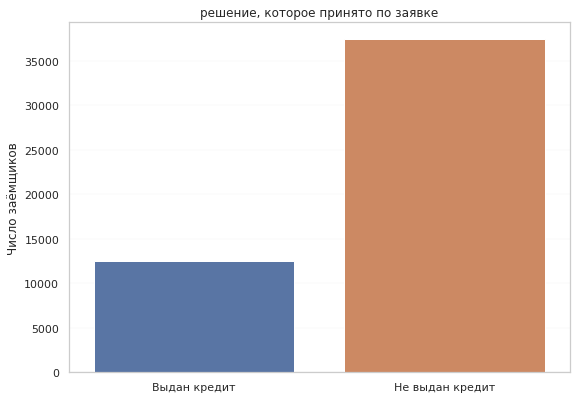

In [226]:
# Посмотрим переменную, которую будем предсказывать
pos = df[df['expert'] == 0].shape[0]
neg = df[df['expert'] == 1].shape[0]
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(8, 6))
sns.countplot(df['expert'])
plt.xticks((0, 1), ['Выдан кредит', "Не выдан кредит"])
plt.ylabel('Число заёмщиков')
plt.xlabel("")
plt.title('решение, которое принято по заявке')

In [227]:
print(f'Одобренно кредитов: {pos}')
print(f'Не одобрили кредитов: {neg}')
print(f'Соотношение одобренных и не одобренных кредитов: {(pos / neg) * 100:.2f}%')

Одобренно кредитов: 12537
Не одобрили кредитов: 37464
Соотношение одобренных и не одобренных кредитов: 33.46%


In [228]:
# Удалим ненужный столбец длч дальнейшего анализа
df = df.drop(['order_date'], axis=1)
df.head()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,cost_all,order_id,client_id,expert
1,143822.0,22,104.12,130068.80,8,756.09,31,0,36,10000.0,10000,196,0.0,0.0,728319,320464,1
2,0.0,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,10000,17,20000.0,0.0,728321,320466,1
3,51356.0,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,10000,84,0.0,0.0,728323,320467,1
4,0.0,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,10000,7,0.0,0.0,728447,320533,1
5,12298.0,1,4942.95,4950.00,2883,4942.95,31,0,47,5000.0,5000,20,0.0,0.0,728421,298598,1


Text(0.5, 1.0, 'Month Income')

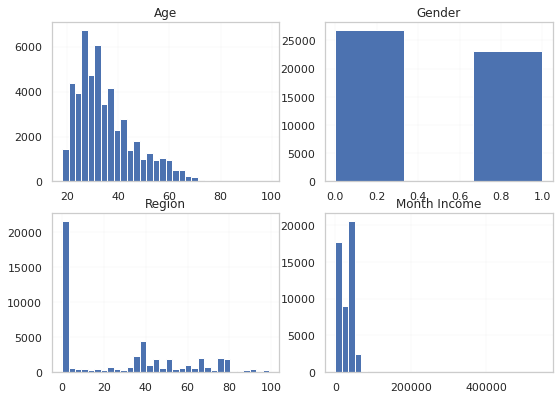

In [229]:
# Взглянем на распределение переменных, характерезующих клиента
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
axes[0, 0].hist(df['age'], bins=32)
axes[0, 0].set_title('Age')

axes[0, 1].hist(df['gender'], bins=3)
axes[0, 1].set_title('Gender')

axes[1, 0].hist(df['region'], bins=32)
axes[1, 0].set_title('Region')

axes[1, 1].hist(df['month_income'], bins=32)
axes[1, 1].set_title('Month Income')


In [233]:
# Посмотрим, переменную Gender
df.gender.value_counts(normalize=True)

0    0.537309
1    0.462691
Name: gender, dtype: float64

In [234]:
df.head()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,cost_all,order_id,client_id,expert
1,143822.0,22,104.12,130068.80,8,756.09,0.160494,0,0.363636,10000.0,10000,196,0.000000,0.0,728319,320464,1
2,0.0,0,38151.93,46230.00,1492,38151.93,0.407407,0,0.939394,10000.0,10000,17,0.036364,0.0,728321,320466,1
3,51356.0,2,3000.00,3000.00,8,3000.00,0.123457,1,0.030303,10000.0,10000,84,0.000000,0.0,728323,320467,1
4,0.0,0,22784.19,32103.52,913,22784.19,0.123457,0,0.525253,10000.0,10000,7,0.000000,0.0,728447,320533,1
5,12298.0,1,4942.95,4950.00,2883,4942.95,0.160494,0,0.474747,5000.0,5000,20,0.000000,0.0,728421,298598,1


**Вывод**

Ознакомившись с нашим набором данных, мы провели следующую предобработку:


*   Удалили столбцы, которые не будут полезны при обучении модели
*   Посмотрели на переменные,характеризующие заёмщика


# Моделирование

In [235]:
# Оценим баланс классов, которые нам необходимо предсказывать в нашей изначальной выборке
df.expert.value_counts(normalize=True)

1    0.749265
0    0.250735
Name: expert, dtype: float64

In [236]:
# Удалим переменную,которую будем предсказывать
X = df.drop('expert', axis=1)
indx = X.index
y = df['expert']

In [237]:
# подготовим наши данные, разобъем всю выборку на три части: обучающую, валидационную и тестовую.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=.3)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, random_state=42, test_size=.5)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
print(f'X_valid: {X_valid.shape}, y_valid: {y_valid.shape}')

X_train: (35000, 16), y_train: (35000,)
X_test: (7501, 16), y_test: (7501,)
X_valid: (7500, 16), y_valid: (7500,)


In [238]:
# Обучим простейшую модель классификации K-ближайших соседей, 
# на не сбалансированном датасете и сравним предсказание данной модели со случайной моделью

for n_neighbors in range(1, 10):
    knc = KNeighborsClassifier(n_neighbors=n_neighbors)
    predicted = knc.fit(X_train, y_train).predict(X_valid)
    probabilities_valid = knc.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    print(f'n: {n_neighbors}\tAccuracy: {round(knc.score(X_train, y_train), 3)}\
    \tF1: {round(f1_score(y_valid.values, predicted),3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

n: 1	Accuracy: 1.0    	F1: 0.895    	ROC AUC: 0.782
n: 2	Accuracy: 0.931    	F1: 0.867    	ROC AUC: 0.828
n: 3	Accuracy: 0.912    	F1: 0.888    	ROC AUC: 0.842
n: 4	Accuracy: 0.893    	F1: 0.877    	ROC AUC: 0.848
n: 5	Accuracy: 0.881    	F1: 0.888    	ROC AUC: 0.855
n: 6	Accuracy: 0.875    	F1: 0.883    	ROC AUC: 0.858
n: 7	Accuracy: 0.865    	F1: 0.888    	ROC AUC: 0.858
n: 8	Accuracy: 0.862    	F1: 0.885    	ROC AUC: 0.858
n: 9	Accuracy: 0.852    	F1: 0.886    	ROC AUC: 0.86


*Будем ориентироваться на F1-меру.*



In [265]:
# Проверим нашу модель на адекватность, сгенерируем псевдослучайную последовательность 0 и 1,
#  равную размером с тестовой выборкой и сравним метрики

y_random = [np.random.randint(0, 2) for i in range(len(y_test))]

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
probabilities_valid = model.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1 на тестовой выборке: {:.3f}".format(f1_score(y_test, predicted)))
print("F1 на случайной выборке: {:.3f}".format(f1_score(y_random, predicted)))

print("ROC AUC на тестовой выборке: {:.3f}".format(roc_auc_score(y_test, probabilities_one_valid)))
print("ROC AUC на случайной выборке: {:.3f}".format(roc_auc_score(y_random, probabilities_one_valid)))

F1 на тестовой выборке: 0.971
F1 на случайной выборке: 0.611
ROC AUC на тестовой выборке: 0.965
ROC AUC на случайной выборке: 0.496


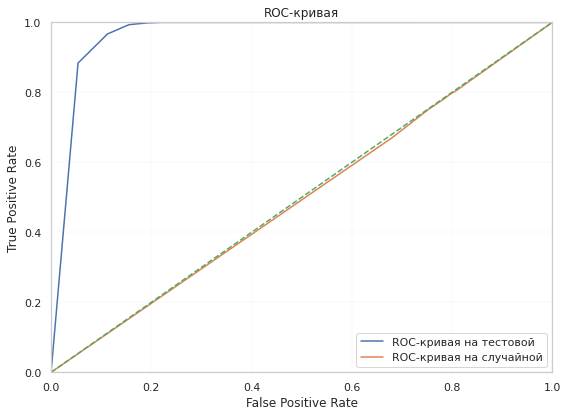

In [266]:
# Построим ROC-кривую
fpr_test, tpr_test, thresholds = roc_curve(y_test, probabilities_one_valid)
fpr_random, tpr_random, thresholds = roc_curve(y_random, probabilities_one_valid)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label='ROC-кривая на тестовой')
plt.plot(fpr_random, tpr_random, label='ROC-кривая на случайной')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Вывод**

Мы провели построение модели класификации методом ближайших соседей на несбланасированом наборе данных и выяснили, что наша модель предсказывает лучше чем случайная модель, но недостаточно хорошо, чтобы данную модель можно было использовать. Есть потенциал роста предсказательной способности. А именно мы можем сбалансировать классы и подобрать более оптимальную модель классификации

**1.   Борьба с дисбалансом**

Ранее мы определили пропорцию дисбалана классов и выяснили, что она примерно равна 75/25.

будем использовать, RobustScaler чтобы стандартизация была менее подвержена влиянию выбросов, т.е. была более надежной


In [241]:
# Исходные данные
X = df.loc[:, df.columns != "expert"].values
y = df.loc[:, df.columns == "expert"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Исходные данные shapes: {X_train.shape, X_test.shape}")

# Очистка двоичных столбцов
train_indices_na = np.max(np.isnan(X_train), axis=1)
test_indices_na = np.max(np.isnan(X_test), axis=1)
X_train_dropna, y_train_dropna = X_train[~train_indices_na, :][:, :-6], y_train[~train_indices_na]
X_test_dropna, y_test_dropna = X_test[~test_indices_na, :][:, :-6], y_test[~test_indices_na]
print(f"Очищенные данные: {X_train_dropna.shape, X_test_dropna.shape}")

# Преобразование данных
mice = IterativeImputer(verbose=0)
X_mice = mice.fit_transform(X)
X_train_mice, X_test_mice, y_train_mice, y_test_mice = train_test_split(
    X_mice, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Преобразование данных: {X_train_mice.shape, X_test_mice.shape}")

Исходные данные shapes: ((40000, 16), (10001, 16))
Очищенные данные: ((40000, 10), (10001, 10))
Преобразование данных: ((40000, 16), (10001, 16))


In [245]:
%%time
# Модель случайный лес классификатор 
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")
pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         X_train_dropna, y_train_dropna,
                         scoring="roc_auc", cv=10, verbose=1)
print(f"Базовая модель средняя AUC: {scores.mean():.3f}")

# Модель со среднеми  данными
pip_impute_mean = make_pipeline(SimpleImputer(strategy="mean"),
                                RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mean,
                         X_train, y_train,
                         scoring="roc_auc", cv=10, verbose=1)
print(f"Модель со среднеми данными средняя AUC: {scores.mean():.3f}")

# Модель с медианными данными
pip_impute_median = make_pipeline(SimpleImputer(strategy="median"),
                                  RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_median,
                         X_train, y_train,
                         scoring="roc_auc", cv=10, verbose=1)
print(f"Модель с медианными данными средняя AUC: {scores.mean():.3f}")


# Модель с преобразованными данными
pip_impute_mice = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mice,
                         X_train_mice, y_train_mice,
                         scoring="roc_auc", cv=10, verbose=1)
print(f"Модель с преобразованными данными средняя AUC: {scores.mean():.3f}")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Базовая модель средняя AUC: 0.901


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Модель со среднеми данными средняя AUC: 0.998


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Модель с медианными данными средняя AUC: 0.998
Модель с преобразованными данными средняя AUC: 0.998
CPU times: user 23min 5s, sys: 1.69 s, total: 23min 6s
Wall time: 23min 6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.8min finished


In [252]:
%%time
# Модель случайного леса классификатор(конфигурация та же)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

# Модель построенная на средней выборке
pip_orig = make_pipeline(SimpleImputer(strategy="mean"), RobustScaler(),rf_clf)                    
scores = cross_val_score(pip_orig,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Модель построенная на средней выборке среднее AUC: {scores.mean():.3f}")

# Модель с Undersampling
pip_undersample = imb_make_pipeline(SimpleImputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomUnderSampler(), rf_clf)
scores = cross_val_score(pip_undersample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Модель с Undersampling средняя AUC: {scores.mean():.3f}")

# модель с передискретизации
pip_oversample = imb_make_pipeline(SimpleImputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomOverSampler(), rf_clf)
scores = cross_val_score(pip_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"модель с передискретизации средняя AUC: {scores.mean():.3f}")

# Модель с EasyEnsemble
resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
pip_resampled = make_pipeline(SimpleImputer(strategy="mean"),
                              RobustScaler(), resampled_rf)
                             
scores = cross_val_score(pip_resampled,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"модель с EasyEnsemble средняя AUC: {scores.mean():.3f}")

# Модель SMOTE
pip_smote = imb_make_pipeline(SimpleImputer(strategy="mean"),
                              RobustScaler(),
                              SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Модель SMOTE: {scores.mean():.3f}")

Модель построенная на средней выборке среднее AUC: 0.998
Модель с Undersampling средняя AUC: 0.997
модель с передискретизации средняя AUC: 0.998
модель с EasyEnsemble средняя AUC: 0.997
Модель SMOTE: 0.998
CPU times: user 47min 26s, sys: 1.83 s, total: 47min 28s
Wall time: 47min 28s


Построим модели, используя три разные модели в качестве базовых обучающихся:

*   Extra Gradient Boosting
*   Support Vector Classifier
*   Random Forest



In [253]:
%%time
# Заменем данные на среднее
imp = SimpleImputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Стандартизуем данные
std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

# Реализуем RandomUnderSampler
random_undersampler = RandomUnderSampler()
X_res, y_res = random_undersampler.fit_sample(X_train, y_train)
# Перемешаем данные
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]
X_res.shape, y_res.shape

((20058, 16), (20058,))



Мы будем использовать логистическую регрессию в качестве метаобучения и k-folds cross validation для проверки и настройки гиперпараметров составной модели. Кроме того, мы построим кривые ROC и AUC с использованием тестовых данных и оценим производительность всех моделей

In [254]:
%%time
# Extra Gradient Boosting
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=1,
                            subsample=0.4,
                            random_state=123)

# Support Vector Classifier
svm_clf = SVC(gamma=0.1,
                C=0.01,
                kernel="poly",
                degree=3,
                coef0=10.0,
                probability=True)

#  Random Forest
rf_clf = RandomForestClassifier(n_estimators=300,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced")

# Определитель обучения
logreg_clf = LogisticRegression(penalty="l2",
                                C=100,
                                fit_intercept=True)

# Установка для голосования CLF
voting_clf = VotingClassifier([("xgb", xgb_clf),
                               ("svm", svm_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)
voting_clf.fit(X_res, y_res)
xgb_model, svm_model, rf_model = voting_clf.estimators_
models = {"xgb": xgb_model, "svm": svm_model,
          "rf": rf_model, "avg_ensemble": voting_clf}

# Первый стек
first_stack = make_pipeline(voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))
# Используйте CV для создания мета-функций 
meta_features = cross_val_predict(first_stack,
                                  X_res, y_res,
                                  cv=10,
                                  method="transform")
# Второй стек
first_stack.fit(X_res, y_res)
second_stack = logreg_clf.fit(meta_features, y_res)



CPU times: user 10min 8s, sys: 1.04 s, total: 10min 9s
Wall time: 10min 9s


# Оценка качества модели

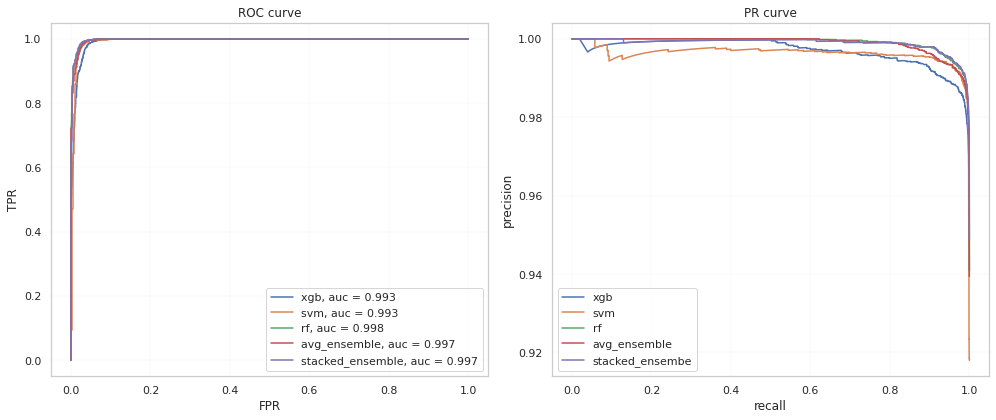

In [255]:
# Постройте кривые ROC и PR, используя все модели и данные испытаний
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
            model_probs = model.predict_proba(X_test)[:, 1:]
            model_auc_score = roc_auc_score(y_test, model_probs)
            fpr, tpr, _ = roc_curve(y_test, model_probs)
            precision, recall, _ = precision_recall_curve(y_test, model_probs)
            axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
            axes[1].plot(recall, precision, label=f"{name}")
stacked_probs = second_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembe")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

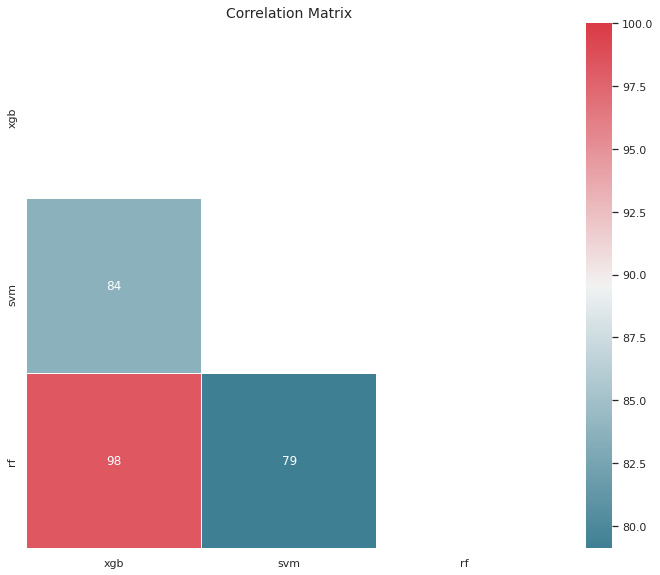

In [257]:
# Построим матрицу корреляций
probs_df = pd.DataFrame(meta_features, columns=["xgb", "svm", "rf"])
corrmat(probs_df.corr(), inflate=True)

<Figure size 1152x576 with 0 Axes>

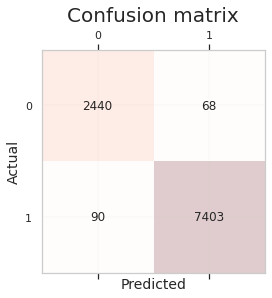

In [258]:
# Построим Confusion matrix
second_stack_probs = second_stack.predict_proba(first_stack.transform(X_test))
second_stack_preds = second_stack.predict(first_stack.transform(X_test))
conf_mat = confusion_matrix(y_test, second_stack_preds)
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

Проверим графики частичной зависимости, чтобы увидеть, каковы наиболее важные характеристики и их взаимосвязь с тем, будет ли заемщик, скорее всего, полностью выплатить ссуду

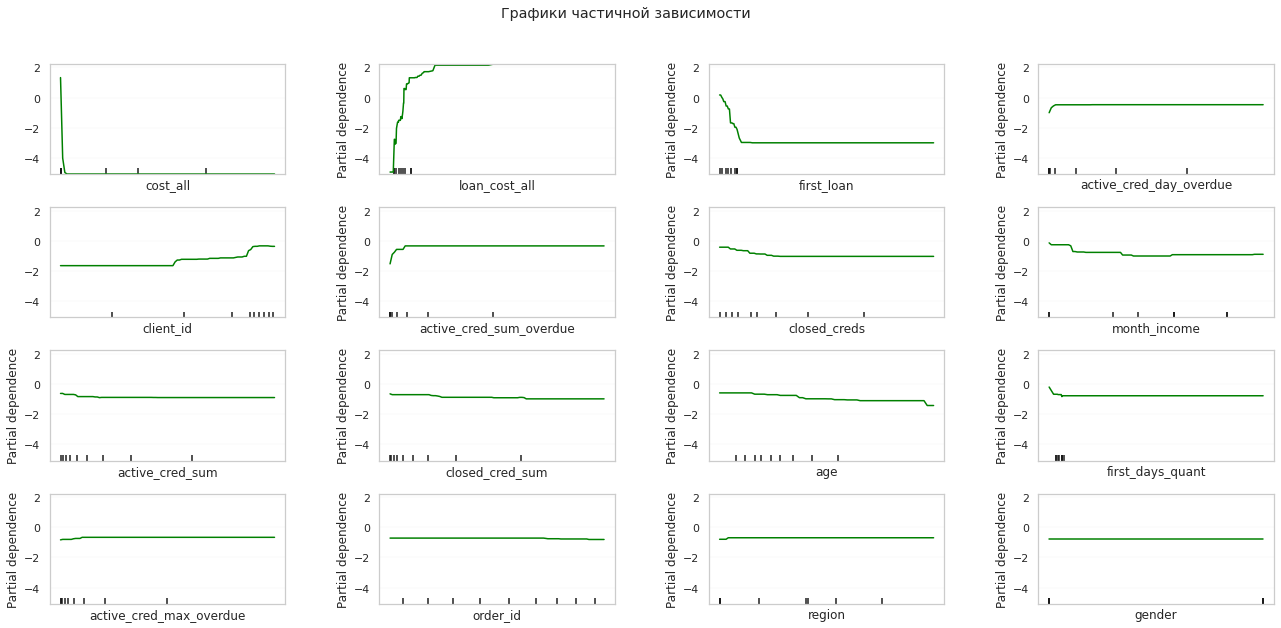

In [268]:
# Построим графики частичной зависимости
gbrt = GradientBoostingClassifier(loss="deviance",
                                  learning_rate=0.1,
                                  n_estimators=100,
                                  max_depth=3,
                                  random_state=123)
gbrt.fit(X_res, y_res)
fig, axes = plot_partial_dependence(gbrt, X_res,
                                    np.argsort(gbrt.feature_importances_)[::-1][:20],
                                    n_cols=4,
                                    feature_names=df.columns,
                                    figsize=(20, 10))
plt.subplots_adjust(top=0.9)
plt.suptitle("Графики частичной зависимости")
for ax in axes: ax.set_xticks(())
for ax in [axes[0], axes[4]]: ax.set_ylabel("")

**Вывод**

Наша модель очень хорошо предсказывает TPR при практически нулевом FPR. Данное обстоятельство может нам сигнализировать, что модель переобучилась на наборе данных, так как в нем присутствовало большое количество повторений событий. Вероятно в тестовый набор попали события, которые были и в обучающем наборе, либо модель действительно хорошо вытянула из набора данных общие закономерности и будет хорошо предсказывать и на неизвестном ей наборе данных

Для более адекватной оценки модели, хорошо было бы иметь отдельный тестовый набор данных.